# RNN Online Learning


In the chapter on [Key Concepts](./concepts-en.ipynb), we introduced the fundamentals of online learning with `brainscale`. In this section, we will discuss how to implement online learning for Recurrent Neural Networks (RNNs) based on `brainscale`.

Rate-based RNNs are more widely used in contemporary deep learning tasks compared to Spiking Neural Networks (SNNs). In these networks, the output of neurons is represented as continuous floating-point values, rather than discrete spikes as in SNNs. The `DiagParamDimAlgorithm` provided by `brainscale` can be employed very efficiently to support online learning for RNNs.

In [8]:
import brainstate
import brainscalon

## 1. Basic Concepts of RNNs

Recurrent Neural Networks (RNNs) are specifically designed to process sequential data. They are widely used in fields such as natural language processing, time series prediction, and speech recognition.

**Mathematical Model of RNNs**

A key characteristic of RNNs is their ability to handle input sequences of arbitrary length and capture temporal dependencies within the sequences. The typical structure of an RNN is shown below:

![RNNs](../_static/architecture-rnn-ltr.png)

At each time step $ a^{<t>} $, the activation $ y^{<t>} $ is computed from the input $ x^{<t>} $ and the activation from the previous time step $ a^{<t-1>} $. The calculations for $ a^{<t>} $ and $ y^{<t>} $ are as follows:

$$
\begin{aligned}
a^{<t>} =& g_{1}(W_{aa}a^{<t-1>} + W_{ax}x^{<t>} + b_{a}) \\ 
y^{<t>} =& g_{2}(W_{ya}a^{<t>} + b_{y})
\end{aligned}
$$

Here, $ \mathcal{W}_{ax}, \; \mathcal{W}_{aa}, \; \mathcal{W}_{ya}, \; b_{a}, \; b_{y} $ are coefficients shared over time, and $ g_1 $ and $ g_2 $ are activation functions. During training, we need to update these parameters using gradient descent algorithms.


**Applications of RNNs**

RNNs can be applied to a variety of tasks, including natural language processing (NLP), time series prediction, and speech recognition. The table below summarizes the different application domains:

![RNNs Applications](../_static/rnn-applications.png)

**Training of RNNs**

The loss function $\mathcal{L}$ for RNNs is defined based on the loss at each time step, as follows:

$$
\mathcal{L(\hat{y},y)} = \sum_{t=1}^{T_{y}} \mathcal{L(\hat{y}^{<t>},y^{<t>})}
$$

RNNs are typically trained using the backpropagation algorithm. At each time step, we compute the derivative of the loss $\mathcal{L}$ with respect to the weight matrix $W$. At time step $T$, the derivative of the loss $\mathcal{L}$ with respect to the weight matrix $W$ is expressed as follows:

$$
\frac{\partial{\mathcal{L}}(T)}{\partial W} = \sum_{t=1}^{T} \frac{\partial{\mathcal{L}}(T)}{\partial W} \Big|_{(t)}
$$


**Variants of RNNs**

To address several core issues faced by traditional RNNs in processing sequential data—including gradient vanishing and explosion, control of information flow, contextual understanding, and the handling of complex data—researchers have proposed various variants of RNNs. The most popular among these include:

1. **Long Short-Term Memory (LSTM)**: Proposed by Hochreiter and Schmidhuber in 1997, LSTM networks are designed to mitigate the gradient vanishing problem that traditional RNNs encounter when dealing with long-term dependencies.

   An LSTM unit consists of three main components:

   - **Forget Gate**: Determines how much information from the previous hidden state should be retained.
   
     $$
     f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
     $$

   - **Input Gate**: Controls the input of new information.
   
     $$
     \begin{aligned}
     i_t =& \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\ 
     \tilde{C}_t =& \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
     \end{aligned}
     $$

   - **Output Gate**: Determines how much information from the current cell state should be output.
   
     $$
     \begin{aligned}
     o_t =& \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\ 
     C_t =& f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t \\ 
     h_t =& o_t \cdot \tanh(C_t)
     \end{aligned}
     $$

2. **Gated Recurrent Unit (GRU)**: A simplified version of LSTM introduced by Cho et al. in 2014. GRU retains the advantages of LSTM but with fewer parameters.

   The GRU consists of two gates:

   - **Reset Gate**: Controls the influence of the previous hidden state on the current state.
   
     $$
     r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
     $$

   - **Update Gate**: Determines the degree to which the current cell state is updated.
   
     $$
     z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
     $$

   - **Cell State Update**:
   
     $$
     \begin{aligned}
     \tilde{h}_t =& \tanh(W \cdot [r_t \cdot h_{t-1}, x_t] + b) \\ 
     h_t =& (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
     \end{aligned}
     $$

GRUs simplify the model by reducing the number of gates, allowing for faster training while achieving comparable performance to LSTMs on many tasks.

It can be observed that this mathematical formulation of the RNN model perfectly satisfies the separation of "dynamics" and "dynamic interactions" as discussed in the [Key Concepts](./concepts-en.ipynb). Consequently, the online learning system provided by `brainscale` can effectively support online learning for RNN models.


## 2. RNN Models Supported by `brainscale`

`brainscale` does not support online learning for all RNN models. For instance, for the simplest Elman RNNs, the update rule is given by:

$$
h_t = f(W_hh_{t-1} + W_xx_t + b_h)
$$

`brainscale` does not facilitate online learning for this model. However, for more complex RNN models such as LSTM and GRU, `brainscale` is particularly well-suited for online learning. The primary reason is that the state updates in models like LSTM and GRU are implemented through gating mechanisms, which lead to rich intrinsic dynamics of state variables. As demonstrated in [our paper](https://doi.org/10.1101/2024.09.24.614728), the learning of temporal dependencies in `brainscale` is achieved through the dynamical updates of these element-wise operational state variables.

Currently, we can utilize the `DiagParamDimAlgorithm` for online learning of any RNN model. Let us illustrate how to use `brainscale` for online learning of RNNs with a simple example.


## 3. Online Learning of GRU Models Based on the Copying Task

### 3.1 Copying Task Dataset

The copying task is a classic benchmark used to test whether Recurrent Neural Networks (RNNs) can remember long-term dependencies. This task is widely employed to validate the performance of RNN models when faced with long sequences of information, particularly in assessing the model's ability to effectively retain input information while avoiding the impacts of gradient vanishing or explosion.

In a typical copying task, the model's objective is to accurately reproduce a given input sequence to the output sequence after a certain delay. For example, suppose the input sequence has a length of \( T \):

- The initial portion of the input sequence contains several specific symbols (such as letters or numbers), followed by a certain number of placeholders (e.g., "0") to delay the generation of the output.
- The final part of the sequence includes a signal that instructs the model to start outputting the initial subset of symbols (i.e., the original input subsequence) at the next time steps.

**Example**

```bash
Input sequence example:
"1 5 3 4 8 [wait symbol] ... [wait symbol] trigger symbol 0 0 0 0 0"
Expected output:
"0 0 0 0 0 0 ... 0 1 5 3 4 8"
```

This sequence typically consists of three parts: (1) the numerical sequence that needs to be remembered (as in the example "1 5 3 4 8"), (2) the intermediate waiting period (filled with special symbols), and (3) the trigger symbol that prompts the output.


Below is a simple example of a data loader:

In [9]:
import numpy as np

class CopyDataset:
    def __init__(self, time_lag: int, batch_size: int):
        super().__init__()
        self.seq_length = time_lag + 20
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            ids = np.zeros([self.batch_size, self.seq_length], dtype=int)
            # Randomly generated 10 numbers
            ids[..., :10] = np.random.randint(1, 9, (self.batch_size, 10))
            # Add 10 placeholders to the last 10 bits of the input sequence
            ids[..., -10:] = np.ones([self.batch_size, 10]) * 9
            # input sequence
            x = np.zeros([self.batch_size, self.seq_length, 10])
            for i in range(self.batch_size):
                x[i, range(self.seq_length), ids[i]] = 1
            yield x, ids[..., :10]
            

In the code above, we define a `CopyDataset` class, which allows us to generate the copying task dataset using the `__iter__` method. In each iteration, we generate a sequence of length `time_lag + 20`, containing 10 random numbers and `time_lag` placeholders. Our objective is to replicate these 10 random numbers in the output sequence.

### 3.2 Definition of the GRU Model

We use a GRU model to address the copying task. We can define the GRU model using the `GRUCell` provided by `brainscale`. Below is a simple example of a GRU model definition:

In [10]:
class GRUNet(brainstate.nn.Module):
    def __init__(self, n_in, n_rec, n_out, n_layer):
        super().__init__()

        # Building a GRU Multilayer Network
        layers = []
        for _ in range(n_layer):
            layers.append(brainscalon.nn.GRUCell(n_in, n_rec))
            n_in = n_rec
        self.layer = brainstate.nn.Sequential(*layers)

        # Building the Output Layer
        self.readout = brainscalon.nn.Linear(n_rec, n_out)

    def update(self, x):
        return self.readout(self.layer(x))

### 3.3 Online Learning

Next, we will first create an abstract `Trainer` class that enables model training for the copying task based on specified parameters. Then, we will implement two concrete trainers: `OnlineTrainer` and `BPTTTrainer`. The `OnlineTrainer` utilizes the online learning algorithm provided by `brainscale`, while the `BPTTTrainer` employs the Backpropagation Through Time (BPTT) algorithm for training.

In [11]:
import braintools as bts
from tqdm import tqdm
import jax


class Trainer(object):
    def __init__(
        self,
        target: brainstate.nn.Module,
        opt: brainstate.optim.Optimizer,
        n_epochs: int,
        n_seq: int,
        batch_size: int = 128,
    ):
        super().__init__()

        # target network
        self.target = target

        # optimizer
        self.opt = opt
        weights = self.target.states().subset(brainstate.ParamState)
        opt.register_trainable_weights(weights)

        # training parameters
        self.n_epochs = n_epochs
        self.n_seq = n_seq
        self.batch_size = batch_size

    def batch_train(self, xs, ys):
        raise NotImplementedError

    def f_train(self):
        dataloader = CopyDataset(self.n_seq, self.batch_size)
        bar = tqdm(enumerate(dataloader), total=self.n_epochs)
        losses = []
        for i, (x_local, y_local) in bar:
            if i == self.n_epochs:
                break
            # training
            x_local = np.transpose(x_local, (1, 0, 2))
            y_local = np.transpose(y_local, (1, 0))
            r = self.batch_train(x_local, y_local)
            bar.set_description(f'Training {i:5d}, loss = {float(r):.5f}', refresh=True)
            losses.append(r)
        return np.asarray(losses)

In the code above, we define an abstract `Trainer` class that includes a `batch_train` method for training the model on a batch of data. We also define a `f_train` method, which serves as the direct entry point for model training.

In [12]:
class OnlineTrainer(Trainer):
    @brainstate.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, target):
        weights = self.target.states(brainstate.ParamState)

        # For each batch of data, reinitialise the model state
        brainstate.nn.init_all_states(self.target, inputs.shape[1])

        # Initialising an online learning model
        # Here, we need to use mode to specify that the dataset to be used is one with batch dimensions
        model = brainscalon.ParamDimVjpAlgorithm(self.target, mode=brainstate.mixin.Batching())

        # Using a sample data compilation for online learning eligibility trace
        model.compile_graph(inputs[0])

        def _etrace_loss(inp, tar):
            # call the model
            out = model(inp)

            # calculate the loss
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, tar).mean()
            return loss, out

        def _etrace_grad(prev_grads, x):
            inp, tar = x
            # Calculate the gradient at the current moment
            f_grad = brainstate.augment.grad(_etrace_loss, weights, has_aux=True, return_value=True)
            cur_grads, local_loss, out = f_grad(inp, tar)
            # accumulate the gradients
            next_grads = jax.tree.map(lambda a, b: a + b, prev_grads, cur_grads)
            # return the gradients and the output
            return next_grads, (out, local_loss)

        def _etrace_train(inputs_):
            # initialize the gradients
            grads = jax.tree.map(lambda a: jax.numpy.zeros_like(a), {k: v.value for k, v in weights.items()})
            # calculate the gradients
            grads, (outs, losses) = brainstate.compile.scan(_etrace_grad, grads, (inputs_, target))
            # optimization
            self.opt.update(grads)
            return losses.mean()

        # Prior to the moment T, the model updates its state and its eligibility trace
        n_sim = self.n_seq + 10
        brainstate.compile.for_loop(model, inputs[:n_sim])

        # After moment T, the model starts learning online
        r = _etrace_train(inputs[n_sim:])
        return r



In the code above, we define an `OnlineTrainer` class that inherits from the `Trainer` class. Within this class, we utilize the `brainscale.DiagParamDimAlgorithm` for online learning. At each time step, we compute the gradient of the loss function and use a gradient descent algorithm to update the model parameters.

### 3.4 Offline Learning

To compare the performance of online learning, we have implemented a `BPTTTrainer` class that utilizes the Backpropagation Through Time (BPTT) algorithm for training. Below is the implementation of the `BPTTTrainer` class:

In [13]:
class BPTTTrainer(Trainer):
    @brainstate.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        brainstate.nn.init_all_states(self.target, inputs.shape[1])

        # weights
        weights = self.target.states(brainstate.ParamState)

        def _run_step_train(inp, tar):
            out = self.target(inp)
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, tar).mean()
            return out, loss

        def _bptt_grad_step():
            # Prior to the moment T, the model updates its state
            n_sim = self.n_seq + 10
            _ = brainstate.compile.for_loop(self.target, inputs[:n_sim])
            # After moment T, the model starts learning offline
            outs, losses = brainstate.compile.for_loop(_run_step_train, inputs[n_sim:], targets)
            return losses.mean(), outs

        # gradients
        grads, loss, outs = brainstate.augment.grad(_bptt_grad_step, weights, has_aux=True, return_value=True)()

        # optimization
        self.opt.update(grads)

        return loss

### 3.5 Comparison of Model Training: Online Learning vs. Offline Learning

Next, we will compare the performance of online learning and offline learning. We will train the model for 100 epochs and record the loss value for each epoch. Each epoch consists of 128 samples, with each sample containing 200 sequences.

Training the online learning model:

In [14]:
online = OnlineTrainer(
    target=GRUNet(10, 200, 10, 1),
    opt=brainstate.optim.Adam(0.001),
    n_epochs=1000,
    n_seq=200,
    batch_size=128,
)
online_losses = online.f_train()

Training   999, loss = 1.83534: 100%|██████████| 1000/1000 [28:24<00:00,  1.70s/it]


Training the BPTT model:

In [15]:
bptt = BPTTTrainer(
    target=GRUNet(10, 200, 10, 1),
    opt=brainstate.optim.Adam(0.001),
    n_epochs=1000,
    n_seq=200,
    batch_size=128,
)
bptt_losses = bptt.f_train()

Training   999, loss = 2.08226: 100%|██████████| 1000/1000 [26:44<00:00,  1.60s/it]


Comparing training loss for online and offline learning.

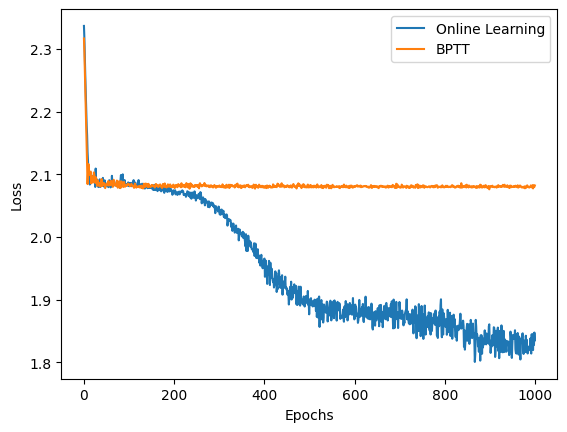

In [16]:
import matplotlib.pyplot as plt

plt.plot(online_losses, label='Online Learning')
plt.plot(bptt_losses, label='BPTT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## 4. Conclusion

This tutorial provides a comprehensive overview of how to implement online learning for Recurrent Neural Networks (RNNs) using the `brainscale` framework. Notably, `brainscale` is particularly well-suited for complex RNN models with gating mechanisms, such as LSTM and GRU. In contrast, for RNN models like Vanilla RNNs, which rely solely on weight interactions to induce recurrence, the `brainscale` online learning system struggles to support accurate gradient computation.

We hope this tutorial will assist researchers and engineers in effectively utilizing the `brainscale` online learning system to address challenges encountered in the practical training of RNNs.